# Light echo exploratory analysis

Question: If spot-modulated reflected light from stars reflects off of planets, does the round trip light travel time give you enough time-separation to see phase shifts in the Kepler/K2 lightcurves?

In [1]:
import astropy.units as u
import astropy.constants as consts

The ratio of planet luminosity to star luminosity depends on albedo.
Assuming albedo $a_{\lambda} \equiv 1$, we have:


$$ \frac{L_p}{L_\star} = \frac{1}{2} \Big(\frac{R_p}{d_p}\Big)^2$$

The light travel time to the planet is:

$$t_p = \frac{d_p}{c}$$

Let's consider a hot Jupiter, at $d_p = 0.05 $ AU.

In [2]:
r_p = 1.0 * u.jupiterRad * 1.0
d_p = 0.05 * u.AU
flux_ratio = 1/2 * (r_p / d_p)**2

In [3]:
L_planet = flux_ratio.to(u.dimensionless_unscaled)
L_planet

<Quantity 4.56766311e-05>

45 part per million.

What is the light travel time?

In [4]:
t_echo = d_p / consts.c
t_echo.to(u.second)

<Quantity 24.95023919 s>

What is the orbital period of this planet?  Assume 1 solar mass host star:

$$ P^2 = a^3$$

In [5]:
P_orb = d_p.to(u.AU).value**(3/2) * 365 
P_orb # days

4.080824058937117

Let's fix the rotation period of the star to 3.75 days.

In [6]:
P_rot = 3.75

Make a simulated lightcurve observation.

In [7]:
import numpy as np
import lightkurve
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
tpf = lightkurve.KeplerTargetPixelFile.from_archive(210698281)
lc = tpf.to_lightcurve(aperture_mask = 'all')

In [9]:
Amp = 0.235
tt = lc.time - lc.time[0]
flux_of_t = lambda t: 1.0 - Amp/2 * np.sin(2.0 * np.pi * (t / P_rot)) - Amp/2
flux_star = flux_of_t(tt)

(0, 1.0117499456153636)

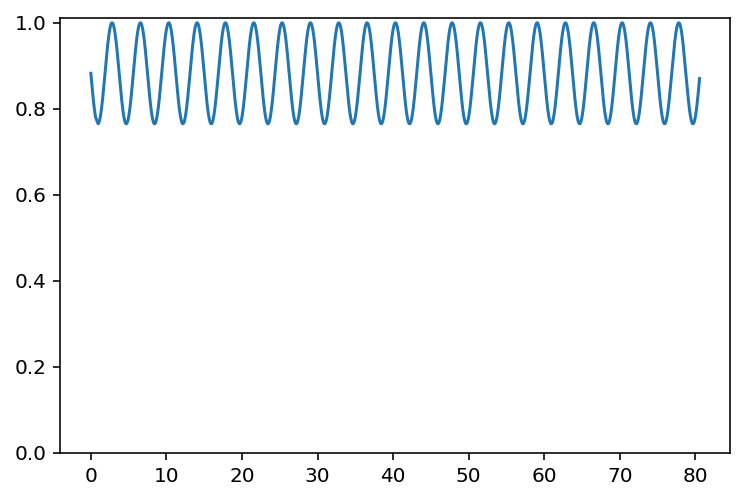

In [10]:
plt.plot(tt, flux_star)
plt.ylim(0)

Simulate the planet reflected light.

In [11]:
theta_0 = 0.0
theta_t = theta_0 + 2.0 * np.pi * tt / P_orb

The portion of light reflected to Earth observers varies with theta.  This function is some complex spherical integration of partially illuminated spheres.  For simplicity let's make a heuristic approximation for the envelope function:

In [12]:
envelope = 0.5 * (1 + np.sin(theta_t))

(0, 6.283185307179586)

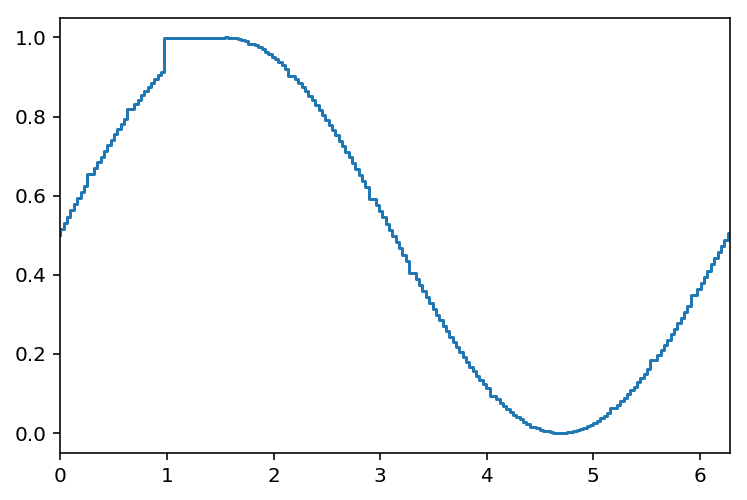

In [13]:
plt.step(theta_t, envelope)
plt.xlim(0, 2.0*np.pi)

The distance from the planet to Earth changes as the planet orbits:

$$ d_t = d_p \sin{\theta}$$

The Round Trip light travel time is:
$$t_{RT} = 2 \, d_t / c = 2 \, t_p \sin{\theta}  $$

In [14]:
time_offset = 2.0 * t_echo.to(u.day).value * np.sin(theta_t)

In [15]:
envelope

array([0.5       , 0.51572706, 0.53143839, ..., 0.00331268, 0.00175111,
       0.00068257])

In [16]:
flux_planet = envelope * L_planet.value * flux_of_t(tt+time_offset)

In [17]:
import seaborn as sns

In [18]:
sns.set_context('talk')

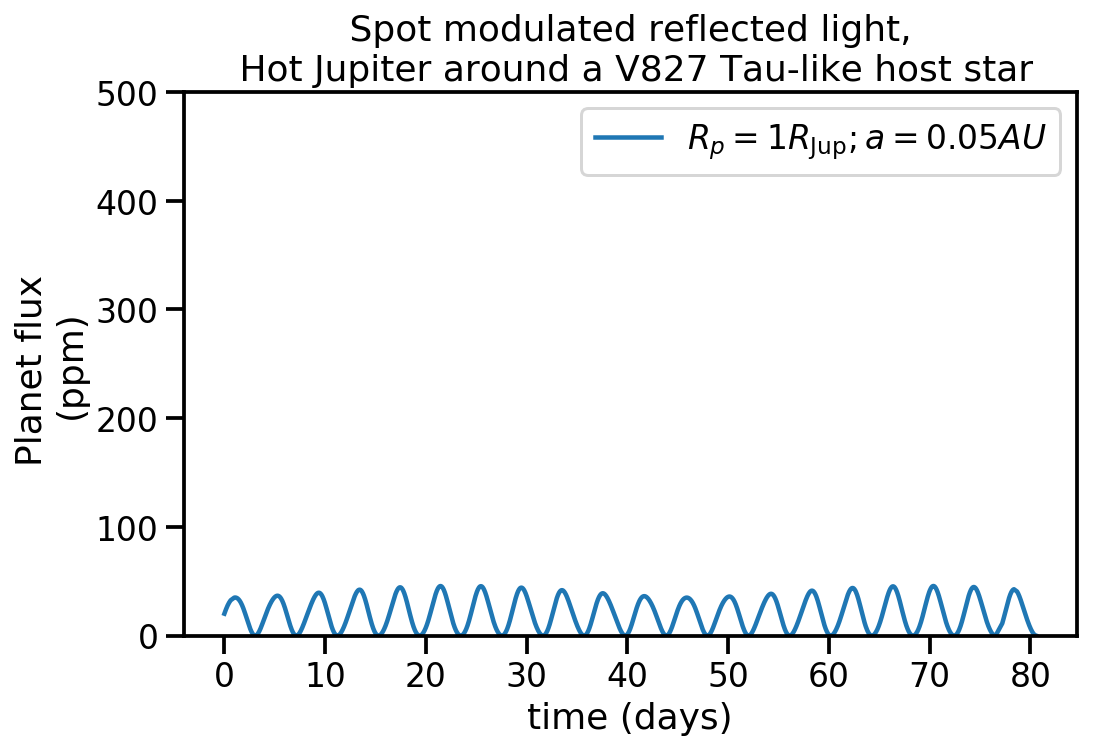

In [19]:
plt.figure(figsize=(8,5))
plt.plot(tt, flux_planet*1.0e6, label = '$R_p = 1 R_{\mathrm{Jup}}; a = 0.05 AU$')
plt.title(' Spot modulated reflected light, \n Hot Jupiter around a V827 Tau-like host star')
plt.ylabel('Planet flux \n(ppm)')
plt.xlabel('time (days)')
plt.ylim(0, 500)
plt.legend(loc='best')

plt.savefig('spot_mod_reflected_hot_jupiter_0p05AU.png', bbox_inches='tight', dpi=300)

In [20]:
! open ../

In [21]:
from astroML.time_series import multiterm_periodogram

In [22]:
norm_err = lc.normalize().flux_err

In [23]:
white_noise = np.random.normal(0, norm_err)

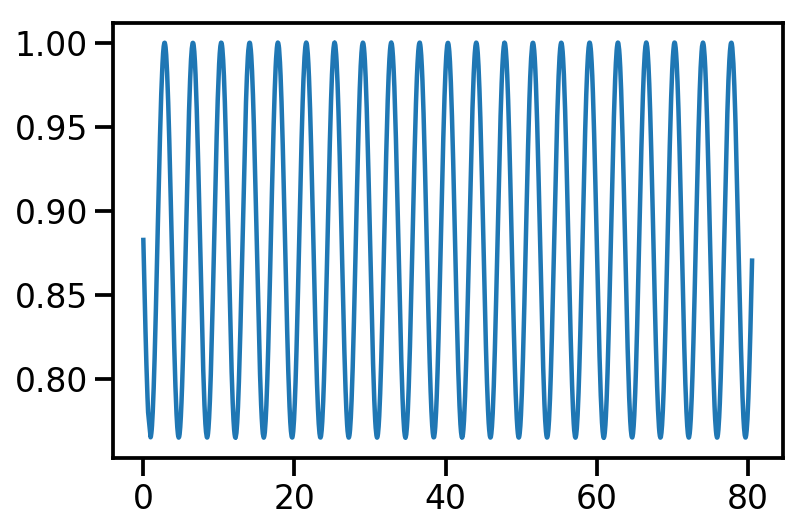

In [24]:
plt.plot(tt, (flux_planet+flux_star)+white_noise )

In [25]:
periods = np.linspace(1, 10, 1000)
omega = 2.0 * np.pi / periods
pgram1 = multiterm_periodogram(tt, flux_star+white_noise, norm_err, omega)
pgram2 = multiterm_periodogram(tt, flux_planet + flux_star+white_noise, norm_err, omega)

/Users/obsidian/anaconda3/envs/lightkurve_env/lib/python3.7/site-packages/astroML/time_series/periodogram.py:176: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M, chi2[i], rank, s = np.linalg.lstsq(X, y)


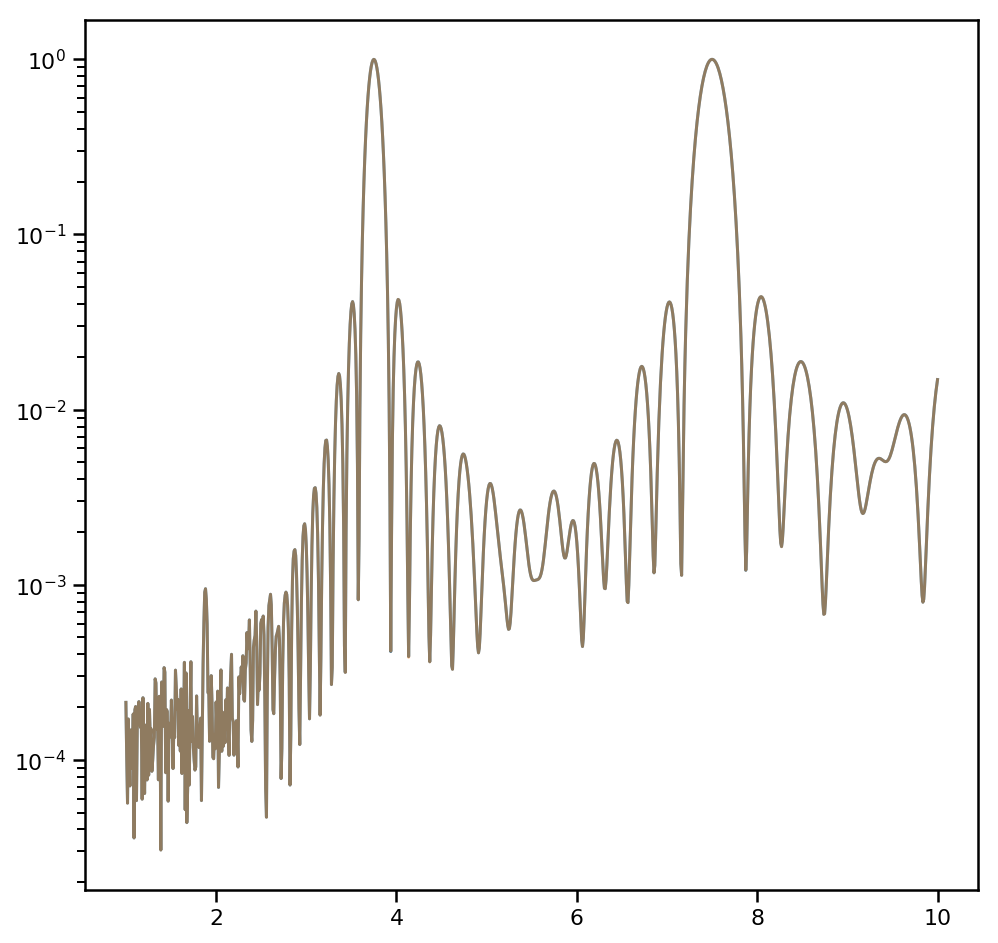

In [26]:
plt.figure(figsize=(8,8))
sns.set_context('notebook')
plt.plot(periods, pgram1)
plt.plot(periods, pgram2, alpha=0.5)
plt.yscale('log')

In [27]:
from scipy.signal import argrelextrema

In [28]:
argrelextrema(flux_star, np.greater)

(array([ 116,  288,  469,  641,  814,  986, 1159, 1332, 1506, 1682, 1857,
        2035, 2207, 2377, 2547, 2713, 2878, 3049, 3219, 3388, 3528]),)

In [29]:
argrelextrema(flux_star+flux_planet, np.greater)

(array([ 116,  288,  469,  641,  814,  986, 1159, 1332, 1506, 1682, 1857,
        2035, 2207, 2377, 2547, 2713, 2878, 3049, 3219, 3388, 3528]),)

Answer: Nah, not really.